# All try code

Disparity: 0.028126739405088662
Transformed points2:
 [[-0.25018543 -0.21492098 -0.12479664]
 [ 0.31063543 -0.38143112 -0.12495838]
 [ 0.2815554   0.3365406  -0.15591559]
 [-0.29547363  0.24439868 -0.06301378]
 [-0.04653178  0.01541282  0.46868439]]


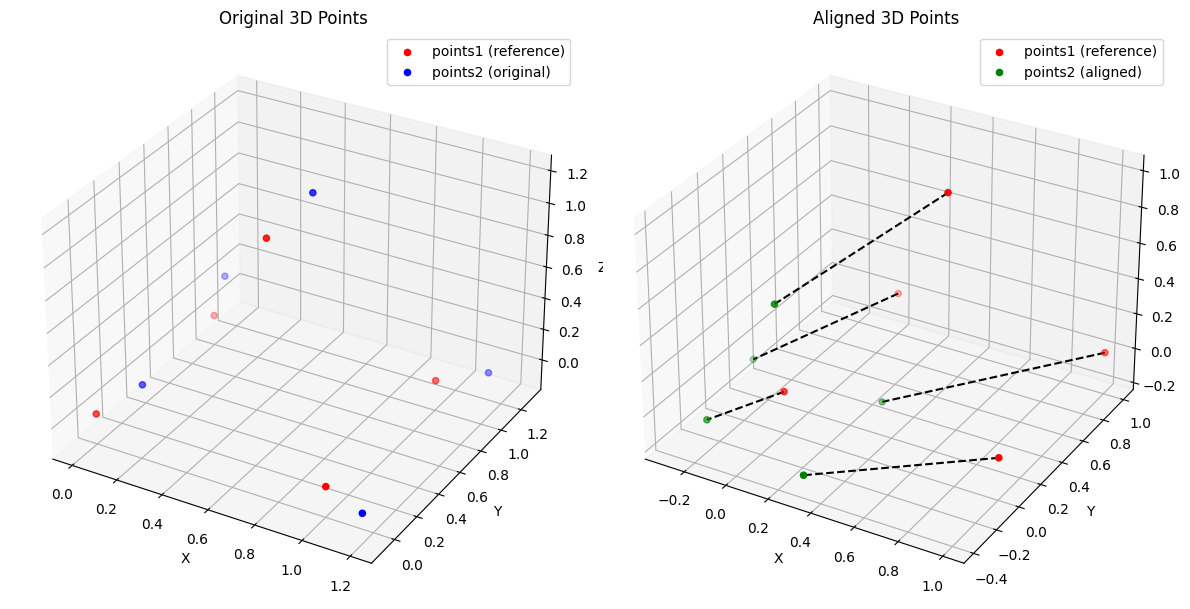

In [2]:
import numpy as np
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define two sets of 3D points
points1 = np.array([
    [0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0],
    [0.0, 1.0, 0.0],
    [0.5, 0.5, 1.0]
])

points2 = np.array([
    [0.1, 0.2, 0.1],
    [1.2, -0.1, 0.0],
    [1.1, 1.3, -0.1],
    [0.0, 1.1, 0.2],
    [0.6, 0.7, 1.2]
])

# Perform Procrustes analysis
mtx1, mtx2, disparity = procrustes(points1, points2)

# Print the results
print("Disparity:", disparity)
print("Transformed points2:\n", mtx2)

# Plot the original and aligned points
fig = plt.figure(figsize=(12, 6))

# Original points
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(points1[:, 0], points1[:, 1], points1[:, 2], color='red', label='points1 (reference)')
ax1.scatter(points2[:, 0], points2[:, 1], points2[:, 2], color='blue', label='points2 (original)')
ax1.set_title('Original 3D Points')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()

# Aligned points
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(points1[:, 0], points1[:, 1], points1[:, 2], color='red', label='points1 (reference)')
ax2.scatter(mtx2[:, 0], mtx2[:, 1], mtx2[:, 2], color='green', label='points2 (aligned)')
for i in range(len(points1)):
    ax2.plot([points1[i, 0], mtx2[i, 0]], [points1[i, 1], mtx2[i, 1]], [points1[i, 2], mtx2[i, 2]], 'k--')

ax2.set_title('Aligned 3D Points')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()

plt.tight_layout()
plt.show()
